In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from optimization import *
torch.set_default_dtype(torch.float64)
from PROGRAMS.data_generating_process import *
from PROGRAMS.likelihood import *
from PROGRAMS.programs import *
from PROGRAMS.run_pyro import *
import time

import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import MCMC, NUTS
import pyro.distributions as dist


['/home/rdoz/miniconda3/envs/myenv/lib/python313.zip', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/lib-dynload', '', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/site-packages', '/home/rdoz/PhD/DeGAS/src']


/home/rdoz/miniconda3/envs/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def neg_log_likelihood(data, dist, idx):
    log_likelihood = torch.log(dist.gm.marg_pdf(data, idx))
    return - torch.sum(log_likelihood)

def run_optimization(name, data, params_init, true_params, eps, sensitivity_analysis=False, lr =0.05, steps = 100):
    soga_code = get_program(name)
    compiledFile = compile2SOGA_text(soga_code)
    cfg = produce_cfg_text(compiledFile)
    smooth_cfg(cfg, smooth_eps=eps)

    params_dict = initialize_params(params_init)  
    output_dist = start_SOGA(cfg, params_dict)
    data_var_list = get_vars(name)
    data_var_index = [output_dist.var_list.index(var) for var in data_var_list]
    data = torch.tensor(data, dtype=torch.float64)
    loss = lambda dist : neg_log_likelihood(data, dist, data_var_index)

    # repeat t
    loss_list, time, iters = optimize(cfg, params_dict, loss, n_steps=steps, lr=lr)

    if sensitivity_analysis:
        error_list = []
        #use the average error
        avg_error = np.mean([abs(params_dict[key].item() - true_value)/abs(true_value) for key, true_value in true_params.items()])
        return avg_error

    # print results:
    for key, value in params_dict.items():
        print(f"{key}: {value.item()}")
    
    # get the true value of the parameters from true_params and compute the relative error
    for key, true_value in true_params.items():
        estimated_value = params_dict[key].item()
        error = abs(estimated_value - true_value)/abs(true_value)
        print(f"Error in {key}: {error}")

    #calculate average error
    avg_error = np.mean([abs(params_dict[key].item() - true_value)/abs(true_value) for key, true_value in true_params.items()])
    print(f"Average error: {avg_error}")
    
    #save losses to a file
    with open(f'losses_csv/loss_{name}.txt', 'w') as f:
        for loss in loss_list:
            f.write(f"{loss}\n")
    # plot the loss
    plt.plot(loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log-Likelihood')
    plt.title(f'Loss over iterations for {name}')
    plt.show()


In [3]:
#set seed for reproducibility
np.random.seed(17) #17
program = 'bernoulli'  # Change this to test other programs
data_size = 1000
true_params, init_params, lr, lr_VI, mcmc_steps, mcmc_warmup = get_params(program)
data = generate_dataset(program, data_size, true_params)

p: 0.5099999999998712  loss: -5295.669565217521
p: 0.5199958529663743  loss: -5303.37279785745
p: 0.5299883626871553  loss: -5310.994209772352
p: 0.5399804478382274  loss: -5318.601357182247
p: 0.5499766140021739  loss: -5326.255593588676
p: 0.5599824096148174  loss: -5334.010998823852
p: 0.5700038967246174  loss: -5341.913397704282
p: 0.5800471561045787  loss: -5349.9994206029505
p: 0.5901178357862013  loss: -5358.295577836273
p: 0.6002207434866951  loss: -5366.817343883289
p: 0.6103594771099707  loss: -5375.568272539918
p: 0.6205360835292423  loss: -5384.539187601635
p: 0.6307507339373406  loss: -5393.707513871474
p: 0.6410014037807111  loss: -5403.036829096109
p: 0.6512835462740997  loss: -5412.476728033037
p: 0.6615897504275438  loss: -5421.963094552331
p: 0.6719093772789996  loss: -5431.418875814567
p: 0.682228171690215  loss: -5440.755443504055
p: 0.692527851903928  loss: -5449.874610229905
p: 0.7027856855113238  loss: -5458.671343952402
p: 0.7129740690544258  loss: -5467.0371890

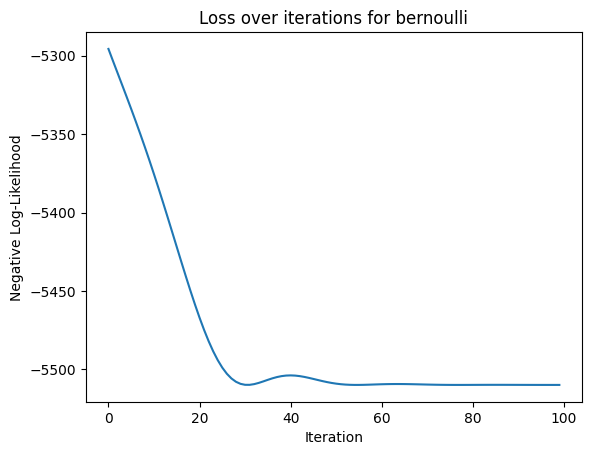

In [4]:
run_optimization(program, data, init_params, true_params, eps=0.001, lr=0.01, steps=100)


p0: 0.2900111413620111 p1: 0.30999999999969446 p2: 0.30999999999988714 p4: 0.2900111413619995  loss: -1597.210794390693
p0: 0.2800273882459993 p1: 0.31991578264070647 p2: 0.31996436855835336 p4: 0.2800273876723032  loss: -1608.674671128927
p0: 0.27363572840800193 p1: 0.3296814547893431 p2: 0.32986661415719526 p4: 0.2736349861727817  loss: -1618.8074599429476
p0: 0.26658501700325926 p1: 0.3392428657428114 p2: 0.33967441738447635 p4: 0.2665585210951734  loss: -1627.6785990623391
p0: 0.2590341836232612 p1: 0.3485345380365582 p2: 0.34935627105296135 p4: 0.25895573004412276  loss: -1635.367897774721
p0: 0.2510816064412128 p1: 0.3574864136985913 p2: 0.35888061148600564 p4: 0.25091990922375607  loss: -1641.9624872908773
p0: 0.24277754827738107 p1: 0.3660278555505784 p2: 0.3682158615069836 p4: 0.24249537347960456  loss: -1647.555116801624
p0: 0.23414788891410712 p1: 0.3740910024724026 p2: 0.3773307279329359 p4: 0.2337027775217058  loss: -1652.2417788119424
p0: 0.22520640365478675 p1: 0.3816137

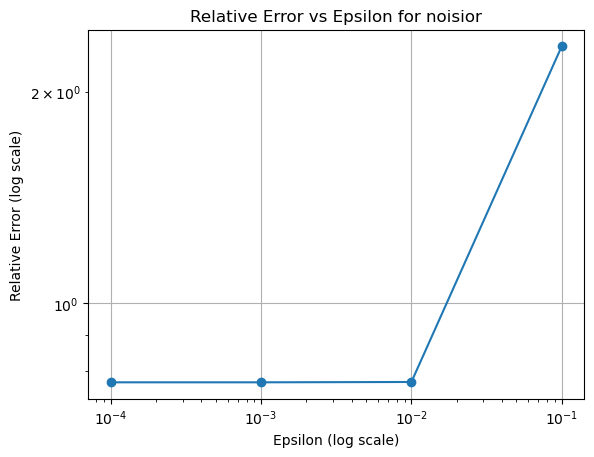

Epsilon: 0.1, Error: 2.3223327349094784
Epsilon: 0.01, Error: 0.7714541829854891
Epsilon: 0.001, Error: 0.7706094518982078
Epsilon: 0.0001, Error: 0.7706025500940012


In [9]:
error_list = []
for eps in [0.1, 0.01, 0.001, 0.0001]:
    #print(f"Running optimization for eps={eps}")
    error = run_optimization(program, data, init_params, true_params, eps=eps, sensitivity_analysis=True, lr=0.01, steps= 100)
    error_list.append(error)

# plot the error as a function of eps
eps_values = [0.1, 0.01, 0.001, 0.0001]
plt.plot(eps_values, error_list, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epsilon (log scale)')
plt.ylabel('Relative Error (log scale)')
plt.title(f'Relative Error vs Epsilon for {program}')
plt.grid(True)
plt.show()

#print the error values
for eps, error in zip(eps_values, error_list):
    print(f"Epsilon: {eps}, Error: {error}")

#save errors to a file
with open(f'errors_csv/errors_{program}.txt', 'w') as f:
    for eps, error in zip(eps_values, error_list):
        f.write(f"{eps},{error}\n")

## variational inference


In [9]:
model, guide = get_model_guide(program)
loss_list, iterations,time = run_inference(model, guide, model_params=(data_size,torch.tensor(data, dtype=torch.float64)), n_steps=1000, lr=lr_VI)
for pyro_param in pyro.get_param_store().get_all_param_names():
    print(f"{pyro_param}: {pyro.param(pyro_param).item()}")

for key, true_value in true_params.items():
        estimated_value = pyro.param(key + "_map").item()
        error = abs(estimated_value - true_value)/abs(true_value)
        print(f"Error in {key}: {error}")

avg_error = np.mean([abs(pyro.param(key + "_map").item() - true_value)/abs(true_value) for key, true_value in true_params.items()])
print(f"Average error: {avg_error}")
print(f"Total inference time: {time} seconds")

pb_map: 0.12393077041906575
pe_map: 0.03754617093289792
Error in pe: 2.754617093289792
Error in pb: 0.23930770419065744
Average error: 1.4969623987402247
Total inference time: 6.766 seconds


## MCMC

In [11]:
import arviz as az
rhat = 2.0
num_samples = 0
warmup_steps = 50

while rhat > 1.05 and num_samples < 10000:
        num_samples += 500
        if num_samples > 2000:
                warmup_steps += 50
        elif num_samples > 5000:
                warmup_steps += 100

        # Run the inference with num_samples=500, warmup_steps=50 and check convergence with R-hat and Neff
        pyro.clear_param_store()
        # Do the same with MCMC
        nuts_kernel = NUTS(model, adapt_step_size=True)
        mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=4)
        start = time.time()
        mcmc.run((data_size, torch.tensor(data, dtype=torch.float64)))
        end = time.time()
        # Get total time
        total_time = end - start
        print(f"Total MCMC runtime: {total_time:.3f} seconds")
        #mcmc.summary()
        samples = mcmc.get_samples(group_by_chain=True)
        idata = az.convert_to_inference_data(samples)
        print(az.summary(idata, round_to=4))
        rhat_all = az.rhat(idata)
        valid_rhat = rhat_all.where(~np.isnan(rhat_all), drop=True)
        rhat = valid_rhat.to_array().max().item()
        neff = az.ess(idata).to_array().min().item()
        print(f"R-hat: {rhat}")
        print(f"Neff: {neff}")


print(f"R-hat maximum: {rhat}")
print(f"Neff minimum: {neff}")
print(f"Num samples: {num_samples}")


for key, true_value in true_params.items():
        estimated_value = torch.mean(samples[key])
        error = abs(estimated_value - true_value)/abs(true_value)
        print(f"Error in {key}: {error}")

avg_error = np.mean([abs(torch.mean(samples[key]) - true_value)/abs(true_value) for key, true_value in true_params.items()])
print(f"Average error: {avg_error}")

Warmup [1]:   0%|          | 0/550 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/550 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/550 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/550 [00:00, ?it/s]

Total MCMC runtime: 148.004 seconds
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p0  0.5122  0.1984  0.1418   0.8203     0.0120   0.0085  267.7244  245.2875   
p1  0.8008  0.0269  0.7538   0.8516     0.0012   0.0006  536.1824  853.0909   
p2  0.0586  0.0268  0.0000   0.0970     0.0015   0.0011  296.8345  121.2647   
p4  0.5146  0.2364  0.0824   0.8597     0.0130   0.0063  262.0472  209.7613   

     r_hat  
p0  1.0123  
p1  1.0049  
p2  1.0118  
p4  1.0089  
R-hat: 1.0123388576611632
Neff: 262.04716582059154
R-hat maximum: 1.0123388576611632
Neff minimum: 262.04716582059154
Num samples: 500
Error in p0: 0.024431942782083604
Error in p1: 0.0009683189334894204
Error in p2: 0.41373035844017697
Error in p4: 0.029189499431035104
Average error: 0.11708002989669627


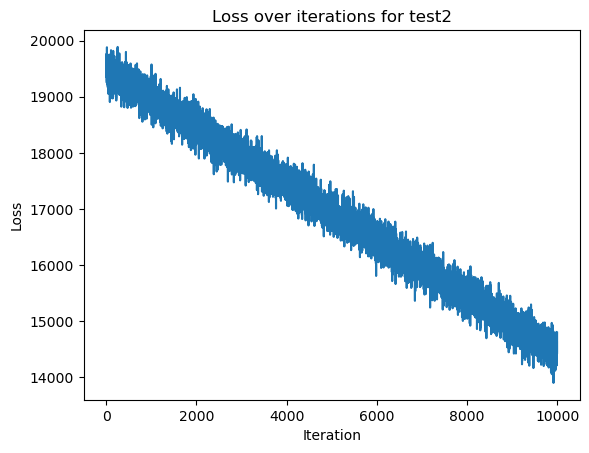

In [12]:
#plot the loss in losses_csv/losses_VI_test.csv
program = 'test2'  # Change this to the program you want to plot
import pandas as pd
import matplotlib.pyplot as plt
#pd.read_csv(f'losses_csv/losses_VI_{program}.csv')
plt.plot(pd.read_csv(f'losses_csv/losses_VI_{program}.csv')['mean'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Loss over iterations for {program}')
plt.show()

In [5]:
soga_code = 'x = uniform([0,1], 2);'
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist  = start_SOGA(cfg, {})
output_dist

Dist<['x'],pi: tensor([[0.5000],
        [0.5000]])
mu: tensor([[0.2500],
        [0.7500]])
sigma: tensor([[[0.0208]],

        [[0.0208]]])>

In [26]:
torch.set_default_dtype(torch.float64)
program = 'pid'
soga_code = get_program(program)
#bernoulli{'_p': 0.7939}
#burglary {'_pe':0.06302589737605023,'_pb':0.132241247142518}
#clickgraph {'_p':0.6462187291480446}
#clinicaltrial= {'_pe':0.05354965966247678,'_pc':0.7972821069295314, '_pt':0.778281508624521}
#params = {'theta':0.717650490965452,'p1':-4.7882963437002735, 'p2':0.6271685683915389}
#params = {'pe':0.05354965966247678,'pc':0.7972821069295314, 'pt':0.778281508624521}
#grass {'_pcloudy':0.5455,'_p1':0.7050,'_p2':0.9101,'_p3':0.8642}
#trueskills {'_pa':105.9900, '_pb': 89.9312,'_pc':119.0213}
#twocoins {'_first':0.3669, '_second':0.3669}
#altermu {'_p1':0.6168,'_p2':0.6168, '_p3':-3.3884}
#altermu2 params = {'_muy':3.5526,'_vary':2.8375}
#pid {'_s0':46.5003, '_s1':-23.4965, '_s2':-0.4951}
#normal mixtures params ={'theta':0.7176,'p1':-4.7883, 'p2':0.6272}

params = {'s0':46.5003, 's1':-23.4965, 's2':-0.4951}
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params)

print(output_dist.gm.mean())
print(output_dist.var_list)


tensor([ 0.5000,  0.5614,  0.7296,  0.9741,  1.2673,  1.5851,  1.9075,  2.2184,
         2.5059,  2.7615,  2.9801,  3.1594,  3.2994,  3.4019,  3.4702,  3.5084,
         3.5211,  3.5132,  3.4894,  3.4543,  3.4119,  3.3657,  3.3188,  3.2734,
         3.2314,  3.1941,  3.1621,  3.1359,  3.1154,  3.1004,  3.0904,  3.0848,
         3.0830,  3.0842,  3.0877,  3.0929,  3.0992,  3.1060,  3.1130,  3.1197,
         3.1259,  3.1315,  3.1362,  3.1401,  3.1432,  3.1455,  3.1470,  3.1478,
         3.1481,  3.1480,  3.1468, -0.0084,  3.1468,  0.0065, -0.0064, -0.0075,
        -0.2030])
['ang[0]', 'ang[1]', 'ang[2]', 'ang[3]', 'ang[4]', 'ang[5]', 'ang[6]', 'ang[7]', 'ang[8]', 'ang[9]', 'ang[10]', 'ang[11]', 'ang[12]', 'ang[13]', 'ang[14]', 'ang[15]', 'ang[16]', 'ang[17]', 'ang[18]', 'ang[19]', 'ang[20]', 'ang[21]', 'ang[22]', 'ang[23]', 'ang[24]', 'ang[25]', 'ang[26]', 'ang[27]', 'ang[28]', 'ang[29]', 'ang[30]', 'ang[31]', 'ang[32]', 'ang[33]', 'ang[34]', 'ang[35]', 'ang[36]', 'ang[37]', 'ang[38]', 'a